# Project C - Wavelets

In [1]:
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools.projectC as im

# Part 1 - Operators

# Q1 - Q3

See imagetools/projectC.py

Code is provided here for convenience

```
class Identity(LinearOperator):
    def __init__(self, shape):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)
        
    def __call__(self, x):
        return x
    
    def adjoint(self, x):
        # note that the adjoint of the identity matrix is the identity matrix itself.
        # it is easy to see this by the definition of a linear operator, noting the commutative property of the inner product    
        return self.__call__(x)

    def gram(self, x):
        # apply the gram matrix to x, which is equivalent to just returning x
        return self.__call__(self.adjoint(x))
    
    def gram_resolvent(self, x, tau):
        # do the inversion by the conjugate gradient
        return cg(lambda z: z + tau * self.gram(z), x)
    
class Convolution(LinearOperator):
    def __init__(self, shape, nu, separable=None):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)

        self._separable = separable
        n1, n2 = ishape[:2]
        self._nu_fft = kernel2fft(nu, n1, n2, separable=self._separable)
        # mu = F^{-1}(conjugate(F(nu))), see assignment 5 for explanation
        self._mu_fft = np.conjugate(self._nu_fft)
        
    def __call__(self, x):
        return convolvefft(x,self._nu_fft)
    
    def adjoint(self, x):
        return convolvefft(x, self._mu_fft)
    
    def gram(self, x):
        # self.adjoint(self.__call__(x),x), reduced to convolvefft(x, nu_fft*mu_fft) by properties of fft
        return convolvefft(x, nu_fft*mu_fft)
    
    def gram_resolvent(self, x, tau):
        # Assuming that boundary is always periodical
        # Just like the Gram LinearOperator, can do the inversion in the Fourier domain when periodical
        res_nu = 1 / (1 + tau * self._nu_fft * self._mu_fft)
        return convolvefft(x, res_nu)
    
class RandomMasking(LinearOperator):
    def __init__(self, shape, p):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)
        
        self._apply_random_mask = np.random.choice(np.array([0,1]), size=oshape, p=[p,1-p])
        
    def __call__(self, x):
        # apply pixel by pixel the random mask
        return self._apply_random_mask * x
    
    def adjoint(self, x):
        # easy to see this is self-adjoint by the definition of a linear operator, noting the commutative property of the inner product 
        return self.__call__(x)

    def gram(self, x):
        # can also be reduced to self._apply_random_mask * x because 0*0=0, 1*0 =0, 0*1=0,1*1=1
        return self.__call__(self.adjoint(x))
    
    def gram_resolvent(self, x, tau):
        return cg(lambda z: z + tau * self.gram(z), x)
```

# Q4

In [2]:
starfish = plt.imread('assets/starfish.png')
x0 = starfish
motion_kernel = im.kernel('motion')

In [3]:
H_identity = im.Identity(x0.shape)
H_convolution = im.Convolution(x0.shape,nu=motion_kernel)
H_random_masking = im.RandomMasking(x0.shape,p=0.4)

In [4]:
y1, y2, y3 = H_identity(x0), H_convolution(x0), H_random_masking(x0)

images for Q4


/opt/conda/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


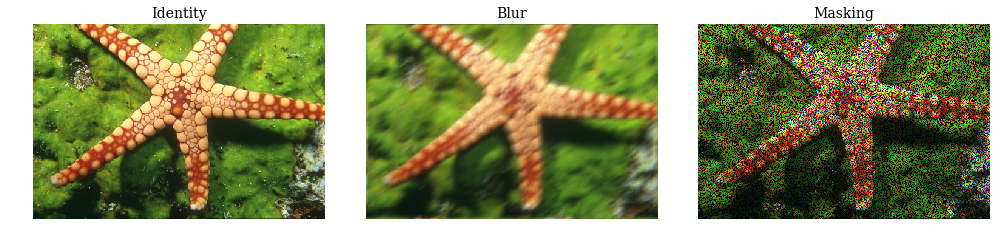

In [5]:
fig,ax = plt.subplots(1, 3,figsize=(14,6))
im.show(y1,ax=ax[0])
ax[0].tick_params(axis='both', which='major', labelsize=10)
ax[0].set_title('Identity',fontdict = {'fontsize' : 14})
im.show(y2,ax=ax[1])
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[1].set_title('Blur',fontdict = {'fontsize' : 14})
im.show(y3,ax=ax[2])
ax[2].tick_params(axis='both', which='major', labelsize=10)
ax[2].set_title('Masking',fontdict = {'fontsize' : 14})
print('images for Q4')

# Q5 assert that〈Hx, y〉=〈x,H∗y〉for any arbitrary arrays x and y of shape H.ishape and H.oshape respectively 

In [6]:
def dot_product(A,B):
    return np.sum(A*B)

def assert_adjoint(x,y,H):
    result = np.isclose(dot_product(H(x),y),dot_product(x,H.adjoint(y)))
    return result

In [7]:
def test_dotproduct_adjoint(totest):
    if totest is 'Identity':
        operator = im.Identity
    elif totest is 'Convolution':
        operator = im.Convolution
    elif totest is 'RandomMasking':
        operator = im.RandomMasking
    # earlier dims between 100 and 400
    a,b = np.random.randint(100,high=400,size=2)
    # later dims need to be 1 or 3 due to kernel2fft
    c,d = np.random.choice(np.array([1,3]), size=2, p=[.5,.5])
    # check for 1D
    if totest is 'Identity':
        H = operator(a)
    elif totest is 'RandomMasking':
        H = operator(a,p=0.2)
    if totest is not 'Convolution':
        x = np.random.rand(H.ishape)
        y = np.random.rand(H.oshape)
        print('1 dimensional case (int) - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # check corner case for 1D
    if totest is 'Identity':
        H = operator((a,))
    elif totest is 'RandomMasking':
        H = operator((a,),p=0.2)
        
    if totest is not 'Convolution':
        x = np.random.rand(*H.ishape)
        y = np.random.rand(*H.oshape)
        print('1 dimensional case (tuple) - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # check 2D
    if totest is 'Identity':
        H = operator((a,b))
    elif totest is 'Convolution':
        H = operator((a,b),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b),p=0.2)
    x = np.random.rand(*H.ishape)
    y = np.random.rand(*H.oshape)
    print('2 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # check 3D
    if totest is 'Identity':
        H = operator((a,b,c))
    elif totest is 'Convolution':
        H = operator((a,b,c),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c),p=0.2)
    x = np.random.rand(*H.ishape)
    y = np.random.rand(*H.oshape)
    print(a,b,c)
    print('3 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # check 4D
    if totest is 'Identity':
        H = operator((a,b,c,d))
    elif totest is 'Convolution':
        H = operator((a,b,c,d),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c,d),p=0.2)
    if totest is not 'Convolution':
        x = np.random.rand(*H.ishape)
        y = np.random.rand(*H.oshape)
        print('4 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # after 4D we can assume it generalizes

# Test run 1

In [8]:
test_dotproduct_adjoint('Identity')

1 dimensional case (int) - input shape is:  (314,) is does Identity test hold?  True
1 dimensional case (tuple) - input shape is:  (314,) is does Identity test hold?  True
2 dimensional case - input shape is:  (314, 331) is does Identity test hold?  True
314 331 3
3 dimensional case - input shape is:  (314, 331, 3) is does Identity test hold?  True
4 dimensional case - input shape is:  (314, 331, 3, 1) is does Identity test hold?  True


In [9]:
test_dotproduct_adjoint('Convolution')

2 dimensional case - input shape is:  (146, 324) is does Convolution test hold?  True
146 324 1
3 dimensional case - input shape is:  (146, 324, 1) is does Convolution test hold?  True


In [10]:
test_dotproduct_adjoint('RandomMasking')

1 dimensional case (int) - input shape is:  (313,) is does RandomMasking test hold?  True
1 dimensional case (tuple) - input shape is:  (313,) is does RandomMasking test hold?  True
2 dimensional case - input shape is:  (313, 300) is does RandomMasking test hold?  True
313 300 3
3 dimensional case - input shape is:  (313, 300, 3) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (313, 300, 3, 3) is does RandomMasking test hold?  True


# Test run 2

In [11]:
test_dotproduct_adjoint('Identity')

1 dimensional case (int) - input shape is:  (332,) is does Identity test hold?  True
1 dimensional case (tuple) - input shape is:  (332,) is does Identity test hold?  True
2 dimensional case - input shape is:  (332, 110) is does Identity test hold?  True
332 110 3
3 dimensional case - input shape is:  (332, 110, 3) is does Identity test hold?  True
4 dimensional case - input shape is:  (332, 110, 3, 1) is does Identity test hold?  True


In [12]:
test_dotproduct_adjoint('Convolution')

2 dimensional case - input shape is:  (260, 327) is does Convolution test hold?  True
260 327 1
3 dimensional case - input shape is:  (260, 327, 1) is does Convolution test hold?  True


In [13]:
test_dotproduct_adjoint('RandomMasking')

1 dimensional case (int) - input shape is:  (326,) is does RandomMasking test hold?  True
1 dimensional case (tuple) - input shape is:  (326,) is does RandomMasking test hold?  True
2 dimensional case - input shape is:  (326, 374) is does RandomMasking test hold?  True
326 374 3
3 dimensional case - input shape is:  (326, 374, 3) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (326, 374, 3, 1) is does RandomMasking test hold?  True


# Test run 3

In [14]:
test_dotproduct_adjoint('Identity')

1 dimensional case (int) - input shape is:  (358,) is does Identity test hold?  True
1 dimensional case (tuple) - input shape is:  (358,) is does Identity test hold?  True
2 dimensional case - input shape is:  (358, 274) is does Identity test hold?  True
358 274 3
3 dimensional case - input shape is:  (358, 274, 3) is does Identity test hold?  True
4 dimensional case - input shape is:  (358, 274, 3, 3) is does Identity test hold?  True


In [15]:
test_dotproduct_adjoint('Convolution')

2 dimensional case - input shape is:  (125, 231) is does Convolution test hold?  True
125 231 1
3 dimensional case - input shape is:  (125, 231, 1) is does Convolution test hold?  True


In [16]:
test_dotproduct_adjoint('RandomMasking')

1 dimensional case (int) - input shape is:  (176,) is does RandomMasking test hold?  True
1 dimensional case (tuple) - input shape is:  (176,) is does RandomMasking test hold?  True
2 dimensional case - input shape is:  (176, 292) is does RandomMasking test hold?  True
176 292 3
3 dimensional case - input shape is:  (176, 292, 3) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (176, 292, 3, 3) is does RandomMasking test hold?  True


# Q6.  Check also that Inverse(Id +τH∗H) (x+τH∗Hx) = x for any arbitrary image x of shape H.ishape.

## Methodology to check: multiply both sides by  Inverse(x+τH∗Hx).
## lhs = H.gram_resolvent applied to x + tau * H.adjoint(H(x))
## rhs = x

In [17]:
def dot_product(A,B):
    return np.sum(A*B)

def assert_gram_resolvent_correct(H,x,tau):
    term = x + tau * H.adjoint(H(x))
    lhs = H.gram_resolvent(term,tau)
    rhs = x
    result = np.allclose(lhs,rhs)
    return result

In [18]:
def test_gram_resolvent(totest,tau):
    if totest is 'Identity':
        operator = im.Identity
    elif totest is 'Convolution':
        operator = im.Convolution
    elif totest is 'RandomMasking':
        operator = im.RandomMasking
    # earlier dims between 100 and 400
    a,b = np.random.randint(100,high=400,size=2)
    # later dims need to be 1 to 4 due to fft in the frequency domain
    c,d = np.random.choice(np.array([1,3]), size=2, p=[.5,.5])
    
    # check 2D
    if totest is 'Identity':
        H = operator((a,b))
    elif totest is 'Convolution':
        H = operator((a,b),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b),p=0.6)
    x = np.random.rand(*H.ishape)
    print('2 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_gram_resolvent_correct(H,x,tau))

    # check 3D
    if totest is 'Identity':
        H = operator((a,b,c))
    elif totest is 'Convolution':
        H = operator((a,b,c),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c),p=0.6)
    x = np.random.rand(*H.ishape)
    print('3 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_gram_resolvent_correct(H,x,tau))

    # check 4D
    if totest is 'Identity':
        H = operator((a,b,c,d))
    elif totest is 'Convolution':
        H = operator((a,b,c,d),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c,d),p=0.6)
    if totest is not 'Convolution':
        x = np.random.rand(*H.ishape)
        print('4 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_gram_resolvent_correct(H,x,tau))

    # after 4D we can assume it generalizes

# Test run 1

In [19]:
test_gram_resolvent('Identity',tau=2)

2 dimensional case - input shape is:  (395, 371) is does Identity test hold?  True
3 dimensional case - input shape is:  (395, 371, 1) is does Identity test hold?  True
4 dimensional case - input shape is:  (395, 371, 1, 1) is does Identity test hold?  True


In [20]:
test_gram_resolvent('Convolution',tau=2)

2 dimensional case - input shape is:  (252, 136) is does Convolution test hold?  True
3 dimensional case - input shape is:  (252, 136, 1) is does Convolution test hold?  True


In [21]:
test_gram_resolvent('RandomMasking',tau=2)

2 dimensional case - input shape is:  (161, 244) is does RandomMasking test hold?  True
3 dimensional case - input shape is:  (161, 244, 3) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (161, 244, 3, 3) is does RandomMasking test hold?  True


# Test run 2

In [22]:
test_gram_resolvent('Identity',tau=2)

2 dimensional case - input shape is:  (211, 135) is does Identity test hold?  True
3 dimensional case - input shape is:  (211, 135, 3) is does Identity test hold?  True
4 dimensional case - input shape is:  (211, 135, 3, 3) is does Identity test hold?  True


In [23]:
test_gram_resolvent('Convolution',tau=2)

2 dimensional case - input shape is:  (368, 336) is does Convolution test hold?  True
3 dimensional case - input shape is:  (368, 336, 1) is does Convolution test hold?  True


In [24]:
test_gram_resolvent('RandomMasking',tau=2)

2 dimensional case - input shape is:  (140, 273) is does RandomMasking test hold?  True
3 dimensional case - input shape is:  (140, 273, 3) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (140, 273, 3, 3) is does RandomMasking test hold?  True


# Test run 3

In [25]:
test_gram_resolvent('Identity',tau=2)

2 dimensional case - input shape is:  (368, 129) is does Identity test hold?  True
3 dimensional case - input shape is:  (368, 129, 1) is does Identity test hold?  True
4 dimensional case - input shape is:  (368, 129, 1, 1) is does Identity test hold?  True


In [26]:
test_gram_resolvent('Convolution',tau=2)

2 dimensional case - input shape is:  (386, 391) is does Convolution test hold?  True
3 dimensional case - input shape is:  (386, 391, 3) is does Convolution test hold?  True


In [27]:
test_gram_resolvent('RandomMasking',tau=2)

2 dimensional case - input shape is:  (179, 124) is does RandomMasking test hold?  True
3 dimensional case - input shape is:  (179, 124, 1) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (179, 124, 1, 1) is does RandomMasking test hold?  True


# Part 2 - Discrete Wavelet Transform

In [28]:
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools.projectC as im
import pywt
from numpy.linalg import inv

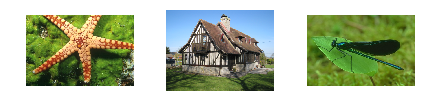

In [29]:
x0=plt.imread('assets/starfish.png')
y=plt.imread('assets/normandy.png')
z=plt.imread('assets/dragonfly.png')
fig, axes = plt.subplots(ncols=3)
im.show(x0, ax=axes[0])
im.show(y, ax=axes[1])
im.show(z, ax=axes[2])

# Q7,8 : Implement DWT function and display

Text(0.5,1,'Its wavelet Coefficient')

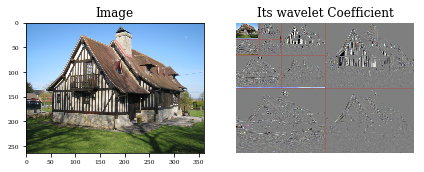

In [30]:
x0=plt.imread('assets/normandy.png')
h,g = im.wavelet('db2')
J=3
x= im.dtw_crop(x0,J)        # Crop x to size of DWT, J=3
z_dwt= im.dwt(x,J,h,g)         # dwt of x

fig, axs = plt.subplots(ncols=2)
axs[0].imshow(x)
axs[0].set_title('Image')
im.showdwt(z_dwt, J)
axs[1].set_title('Its wavelet Coefficient')


# Q9: Implement IDWT function :
# Solved in ProjectC.py

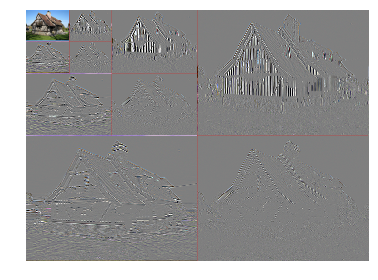

In [31]:
plt.figure()
im.showdwt(z_dwt,J)

# Q10: Check DWT and IDWT vs Inverse version
# DWT -> IDWT:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


** Display shows that the proof correctly


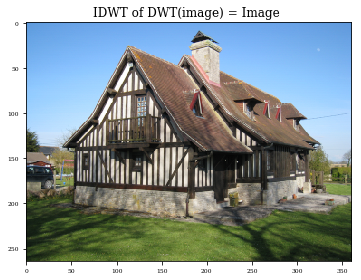

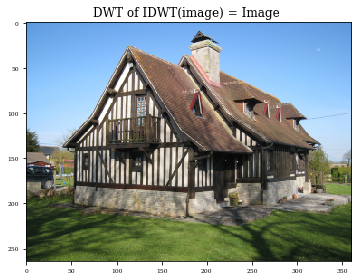

In [32]:
z_dwt= im.dwt(x,J,h,g) 
z_idwt = im.idwt(z_dwt,J,h,g)

fig, axs = plt.subplots()
axs.imshow(z_idwt)
axs.set_title('IDWT of DWT(image) = Image ')

     # IDWT -> DWT
x_idwt = im.idwt(x,J,h,g)
x= im.dwt(x_idwt,J,h,g) 
fig, axs = plt.subplots()
axs.imshow(x)
axs.set_title('DWT of IDWT(image) = Image ')
print('** Display shows that the proof correctly')


# Q11: Implement Invert() , Power(), use Class DWT :
# DWT -> IDWT

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


** Invert() show the proof correctly
(264, 360, 3)
(264, 360, 3)
(264, 360, 1)
** np.isclose(p,p1)=True, shows that power(self) was implemented correctly to match with dwt_power(n1,n2,J)


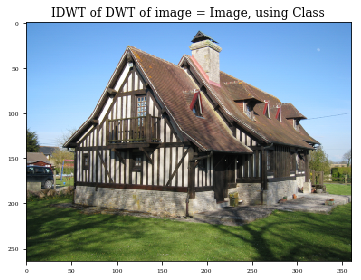

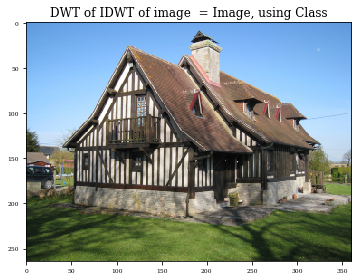

In [33]:
x0=plt.imread('assets/normandy.png')
W= im.DWT(x.shape,J, name='db2')  # Call Object W from class DWT
x0=im.dtw_crop(x0,J)
z_dwt = W(x0)                # Take DWT
x_idwt = W.invert(z_dwt)              # Take IDWT

fig, axs = plt.subplots()
axs.imshow(x_idwt)
axs.set_title('IDWT of DWT of image = Image, using Class')

        # DWT -> IDWT  
x_idwt = W.invert(x0)              # Take IDWT
x = W(x_idwt)             # Take DWT
fig, axs = plt.subplots()
axs.imshow(x)
axs.set_title('DWT of IDWT of image  = Image, using Class')

print('** Invert() show the proof correctly')

    # Check if Power(self) = dwt_power(n1,n2,J)
print(x0.shape)
x=im.dtw_crop(x0,J)
print(x.shape)
n1,n2= x.shape[:2]
p1= im.dwt_power(n1,n2,J,)
p= W.power()
print(p.shape)
#print(p1.shape)
#print(p[:,0])

np.isclose(p,p1)
print('** np.isclose(p,p1)=True, shows that power(self) was implemented correctly to match with dwt_power(n1,n2,J)')


# Q12: Thresholding ( refer to ProjectC.py)

# Q13: Denoise 

(320, 480, 3)


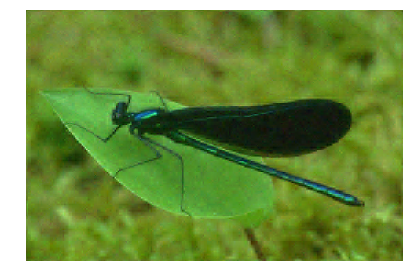

In [34]:
sig= 20/255
x=plt.imread('assets/dragonfly.png')
x0= im.dtw_crop(x,J)
y_noise= x0 + sig * np.random.randn(*x0.shape)
W= im.DWT(y_noise.shape,J, name='db2')             # Call Object W from class DWT

y_denoise = im.softthresh_denoise(y_noise, sig, W, alpha=10/255)
plt.figure()
im.show(y_denoise)
print(x0.shape)
#plt.figure()
#im.show(y_noise)

# Q14: Plot PSNR

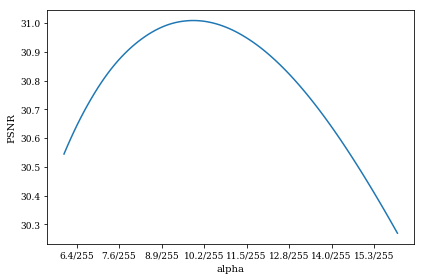

In [45]:
k=np.linspace(0,9,num=100)
psnrs= np.zeros(k.shape)
alpha= np.zeros(k.shape)

for i,num in enumerate(k):
    y_denoise= im.softthresh_denoise(y_noise, sig, W, alpha=(6+num)/255)
    psnrs[i] = im.psnr(x0,y_denoise)
    alpha[i] = (5.1+num)/255
    
def plot():
    fig, axs = plt.subplots()
    axs.plot(alpha,psnrs)
    axs.tick_params(axis='both', which='major', labelsize=10)
    axs.set_xlabel('alpha',fontdict = {'fontsize' : 12})
    axs.set_ylabel('PSNR',fontdict = {'fontsize' : 12})

    # get ticks
    a = axs.get_xticks().tolist()
    # convert ticks to str version
    a = ['{:.2f}/255'.format(i*255) for i in a]
    axs.set_xticklabels(a)
    
plot()

# Part 4 - Wavelet Based Imaged Restoration

# Q22

In [46]:
# page 154/104 gives details on sparse regularization    
def sparse_analysis_regularization(y, sig, W, H=None, m=40, alpha=10/255,
                                   gamma=1, return_energy=False):
    if H is None:
        H_sparse = im.Identity(y.shape)
    else:
        H_sparse = H
            
    class ADMM:
        def __init__(self):
            self.list_lambda = (alpha * W.power()) # see q13, list_lambda contains list of lambda_i
            self.Lambda = np.diag(np.reciprocal(self.list_lambda.flatten())) # (note capital) Lambda^(-1/2).
            self.m = y.size

            self._x = H_sparse.adjoint(y)
            self._z = W(self._x)
            self._dx , self._dz = 0 , 0

        def update(self, m,return_energy=False):
            # update m times
            if return_energy:
                e = []
                
            for i in range(m):
                x = H_sparse.gram_resolvent(self._x + self._dx + gamma * H_sparse.adjoint(y), tau=gamma)
                if i==0:
                    self.n = W(x).size
                    self.tau = np.sqrt(2*np.sqrt(self.m/self.n)) * sig**2
                
                z = im.softthresh(self._z + self._dz, (gamma*self.tau) / self.list_lambda)
                self._x = W.gram_resolvent(x - self._dx + W.adjoint(z - self._dz), tau=1)
                self._z = W(self._x)
                self._dx = self._dx - x + self._x
                self._dz = self._dz - z + self._z
                
                print(im.psnr(x0,x),self.energy(x))
                if return_energy:
                    e.append(self.energy(x))
            if return_energy:
                return x
            else:
                return x,e

        def energy(self,x):
            left_term = np.sum((y - H_sparse(x))**2) / 2
            print(x.shape)
            print(W(x).shape)
            right_term = self.tau*np.sum(np.abs(self.Lambda.dot(W(x))))
            return left_term + right_term
    
    step = ADMM()
            
    if return_energy:
        x,e = step.update(m,return_energy)
        return x, e
    else:
        x = step.update(m,return_energy)
        return x

# Q23

In [47]:
x0 = plt.imread('assets/dragonfly.png')
x0 = im.dtw_crop(x0,J=3)
sig = 20/255
y = x0 + sig * np.random.randn(*x0.shape)

In [48]:
W_dwt = im.DWT(y.shape, J=3, name='db2')
y_dwt = sparse_analysis_regularization(y, sig, W_dwt,m=3)
W_udwt = im.UDWT(y.shape, J=3, name='db2',using_fb=True)
y_udwt = sparse_analysis_regularization(y, sig, W_udwt,m=100)
im.show(y_udwt)

(320, 480, 3)
(320, 480, 3)


ValueError: shapes (153600,153600) and (320,480,3) not aligned: 153600 (dim 1) != 480 (dim 1)

In [ ]:
im.psnr(x0,y_udwt)

For the above, maybe plot. Interpret the results.About how many iterations are required before the energy plateaus?

In [ ]:
y1 = softthresh_denoise(y,sig,W_dwt)
y2 = softthresh_denoise(y,sig,W_udwt)

In [ ]:
# plot as in q23
fig,ax = plt.subplots(2, 2,figsize=(14,6))
im.show(y,ax=ax[0,0])
ax[0,0].set_title('Noisy {} dB'.format(psnr(x0,y))),fontdict = {'fontsize' : 11})
im.show(y1,ax=ax[0,1])
ax[0,1].set_title('Softthresh DWT {} dB'.format(psnr(x0,y2)),fontdict = {'fontsize' : 11})
im.show(y2,ax=ax[1,0])
ax[1,0].set_title('Softthresh UDWT {} dB'.format(psnr(x0,y3)),fontdict = {'fontsize' : 11})
im.show(y_udwt,ax=ax[1,1])
ax[1,1].set_title('Sparse Analysis Regularization UDWT {} dB'.format(psnr(x0,y_udwt)),fontdict = {'fontsize' : 11})
print('images for Q4')

# Q24

In [ ]:
x0 = plt.imread('assets/topgun.png')
sig = 2/255
y = x0 + sig * np.random.randn(*x0.shape)
gamma = 100
H_conv = im.Convolution(x0.shape,nu=motion_kernel)

## TODO: Check the evolution of the loss by printing the energy / x after a number of iterations

In [ ]:
W_dwt = im.DWT(y.shape, J=3, name='db2')
y_dwt = sparse_analysis_regularization(y, sig, W_dwt,H=H_conv,m=1)

In [ ]:
y_dwt = sparse_analysis_regularization(y, sig, W_dwt,H=H_conv,m=5)

In [ ]:
y_dwt = sparse_analysis_regularization(y, sig, W_dwt,H=H_conv,m=10)

In [ ]:
y_dwt = sparse_analysis_regularization(y, sig, W_dwt,H=H_conv,m=40)

In [ ]:
W_udwt = im.UDWT(y.shape, J=3, name='db2', using_fb=True)
y_udwt = sparse_analysis_regularization(y, sig, W_udwt,H=H_conv,m=1)


In [ ]:
y_udwt = sparse_analysis_regularization(y, sig, W_udwt,H=H_conv,m=3)
print(im.psnr(x0,y_udwt))

In [ ]:
print(im.psnr(x0,y_udwt))

In [ ]:
y_udwt = sparse_analysis_regularization(y, sig, W_udwt,H=H_conv,m=5)
print(im.psnr(y_udwt,x0))

In [ ]:
y_udwt = sparse_analysis_regularization(y, sig, W_udwt,H=H_conv,m=40)
print(im.psnr(y_udwt,x0))

## Plot results as in q24

In [ ]:
y1 = H_conv(y) # blur
y2 = y_dwt
y3 = y_udwt

fig,ax = plt.subplots(1, 3,figsize=(14,6))
im.show(y1,ax=ax[0])
ax[0].set_title('Blurry',fontdict = {'fontsize' : 14})
im.show(y2,ax=ax[1])
ax[1].set_title('SAR with DWT {} dB '.format(psnr(x0,y2)),fontdict = {'fontsize' : 14})
im.show(y3,ax=ax[2])
ax[2].set_title('SAR with UDWT {} dB '.format(psnr(x0,y3)),fontdict = {'fontsize' : 14})
print('images for Q4')

# Extra Credit

## For extra credit we can implement both or one of the following
## - In denoising, for different noise levels and parameters, compare your wavelet implementation withthe one of Scikit image:skimage.restoration.denoisewavelet
## - Implement and compare with sparse synthesis regularization.

In [ ]:
from skimage.restoration import denoise_wavelet

In [ ]:
# synthesis vs analysis is described starting from page 104 and after. 